In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import combinations

In [4]:
def metric_df(df):
    truth = np.array(df['truth'])
    pred = np.array(df['pred'])
    diff = abs(pred - truth) / truth
#     print(list(diff <= 0.1).count(True) / len(diff))
    return list(diff <= 0.1).count(True) / len(diff)

In [5]:
test = pd.read_csv('dataset/test.csv')
train = pd.read_csv('dataset/train.csv')

valid_result_1 = pd.read_pickle('./output/xgb_area_kfold_valid_result.pkl')
submission = pd.read_csv('./output/submission_xgb_area_kfold_trainByAlltrain.csv')

valid_result_2 = pd.read_pickle('./output/lgbm_area_kfold_valid_result.pkl')
submission2 = pd.read_csv('./output/submission_lgbm_area_kfold_trainByAlltrain.csv')

In [12]:
def ensemble_by_previous_validate_group_accuracy(sub1, sub2, test, valid, cols, val_result_1, val_result_2):
    ### all arg. are series

    sub1_val_groupacc = val_result_1.groupby(cols).apply(metric_df) ###
#     print(sub1_val_groupacc)
    sub2_val_groupacc = val_result_2.groupby(cols).apply(metric_df) ###
    test_col_value = test.loc[:, cols]
    per_group_count = valid.groupby(cols).agg({'building_id': ['count']})
    
    sub1.sort_index(inplace=True)
    sub2.sort_index(inplace=True)
    test_col_value.sort_index(inplace=True) ###
    per_group_count.sort_index(inplace=True)
    subdf = pd.concat([sub1, sub2, test_col_value], axis=1) ###
    subdf['applymore_sub2'] = pd.Series()
    subdf['applymore_sub1'] = pd.Series()
    subdf['apply_avg'] = pd.Series()
    subdf['ensemble'] = pd.Series()
    
    sub1_val_groupacc.sort_index(inplace=True)
    sub2_val_groupacc.sort_index(inplace=True)
    valdf = pd.concat([sub1_val_groupacc, sub2_val_groupacc], axis=1)
#     print(valdf)
    
    print(sum(subdf.iloc[:, 2].isin(list(np.where(valdf.iloc[:, 0] > valdf.iloc[:, 1])[0]))), \
          sum(subdf.iloc[:, 2].isin(list(np.where(valdf.iloc[:, 0] < valdf.iloc[:, 1])[0]))), \
          sum(subdf.iloc[:, 2].isin(list(np.where(valdf.iloc[:, 0] == valdf.iloc[:, 1])[0]))))
    
    val2_greater_group = list(np.where(valdf.iloc[:, 0] < valdf.iloc[:, 1])[0]) ###
    val1_greater_group = list(np.where(valdf.iloc[:, 0] > valdf.iloc[:, 1])[0]) ###
    
    subdf['applymore_sub2'] = subdf.iloc[:, 2].isin(val2_greater_group) ###
    subdf['applymore_sub1'] = subdf.iloc[:, 2].isin(val1_greater_group)
    subdf['apply_avg'] = ~subdf.iloc[:, 2].isin(val1_greater_group + val2_greater_group)
    
#     subdf['ensemble'] = subdf.iloc[:, 1] * subdf['apply_sub2'] * 0.5 + subdf.iloc[:, 0] * subdf['apply_sub2'] * 0.5 + \
#                         subdf.iloc[:, 0] * subdf['apply_sub1']
    subdf['ensemble'] = subdf.iloc[:, 1] * subdf['applymore_sub2'] * 0.55 + subdf.iloc[:, 0] * subdf['applymore_sub2'] * 0.45 + \
                        subdf.iloc[:, 0] * subdf['applymore_sub1'] * 0.55 + subdf.iloc[:, 1] * subdf['applymore_sub1'] * 0.45 + \
                        subdf.iloc[:, 0] * subdf['apply_avg'] * 0.5 + subdf.iloc[:, 1] * subdf['apply_avg'] * 0.5
            
#     print(subdf)
    return subdf['ensemble']



# per_town_count = train.groupby('town').agg({'building_id': ['count']})
ts = time.time()
result = ensemble_by_previous_validate_group_accuracy(submission['total_price'].reset_index(drop=True), 
                                                      submission2['total_price'], test, train, ['city'],
                                                      valid_result_1, valid_result_2)
print(time.time() - ts)
# result

184 4553 0
0.40438294410705566


In [13]:
submission3 = pd.DataFrame({
    "building_id": test.building_id, 
    "total_price": result
})
submission3.to_csv('./output/submission_xgb_area_lgbm_area_kfold_city_ensemble.csv', index=False)

In [6]:
sum(submission3.total_price == submission2.total_price)

1

In [9]:
def ensemble_by_previous_validate_group_accuracy(valid, cols, val_result_1, val_result_2):
    ### all arg. are series

    sub1_val_groupacc = val_result_1.groupby(cols).apply(metric_df)
    sub2_val_groupacc = val_result_2.groupby(cols).apply(metric_df)
    per_group_count = valid.groupby(cols).agg({'building_id': ['count']})
    
    sub1_val_groupacc.sort_index(inplace=True)
    sub2_val_groupacc.sort_index(inplace=True)
    per_group_count.sort_index(inplace=True)
    
    df_plot = pd.DataFrame({
        "groupacc_diff": sub1_val_groupacc - sub2_val_groupacc, 
        "per_group_count": per_group_count.iloc[:, 0]
    })
    plt.scatter(df_plot.groupacc_diff, df_plot.per_group_count)
    plt.title(cols)
    plt.show()
    
   

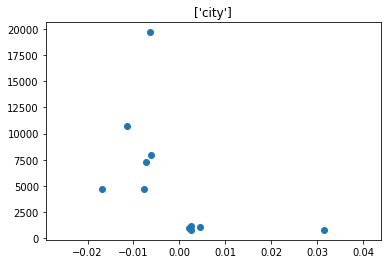

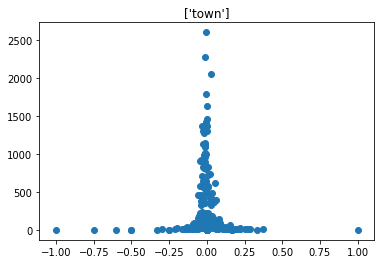

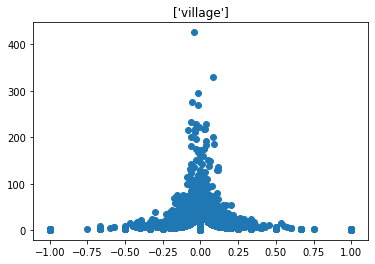

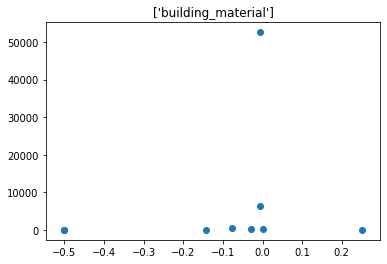

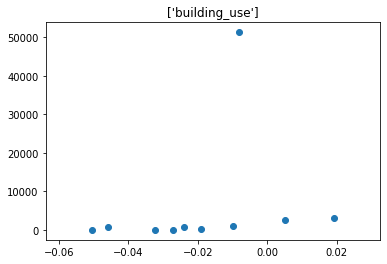

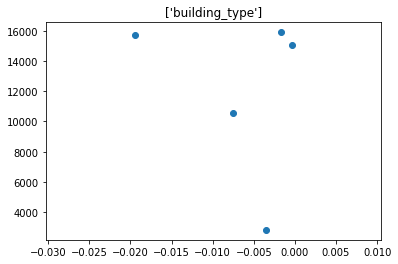

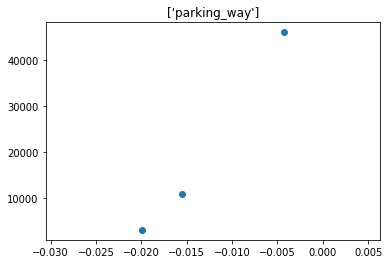

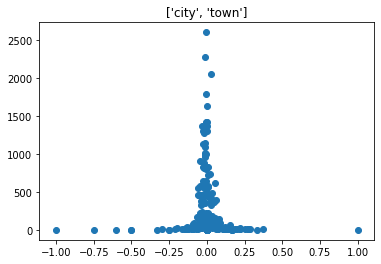

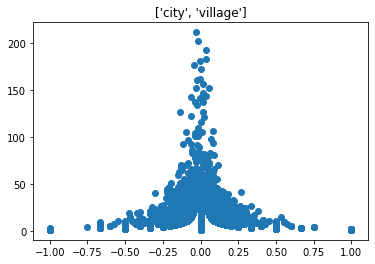

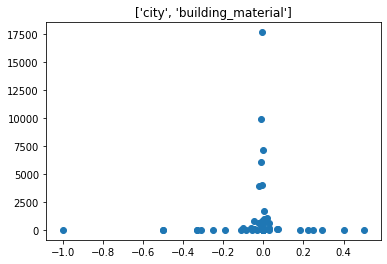

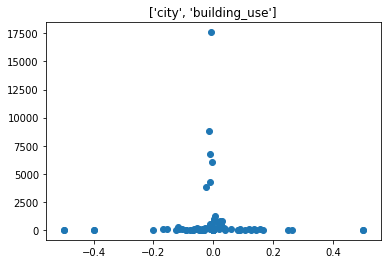

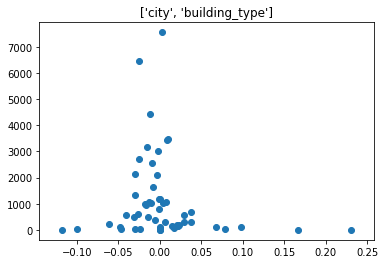

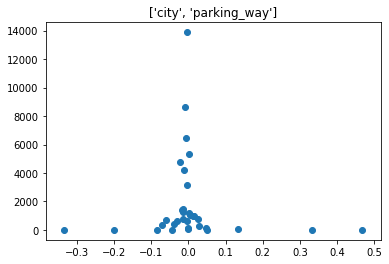

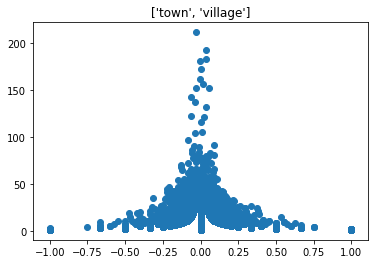

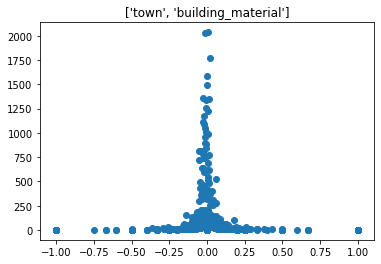

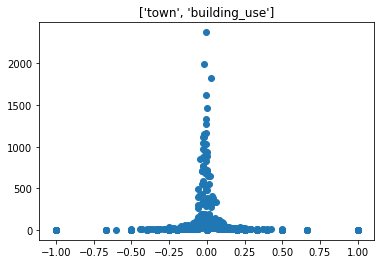

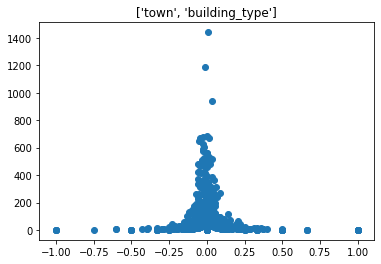

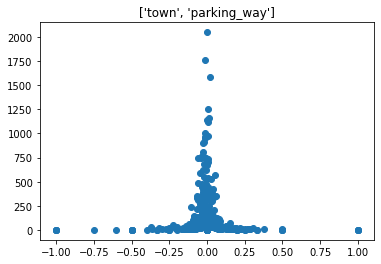

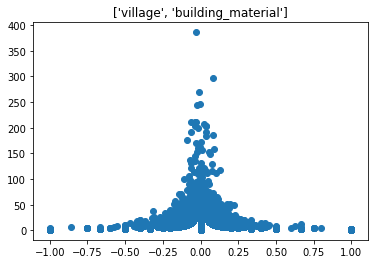

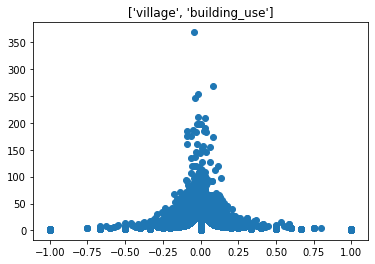

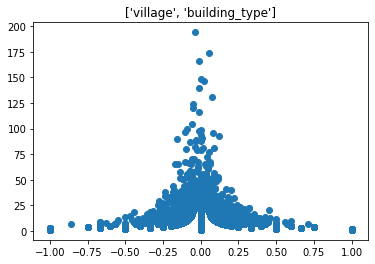

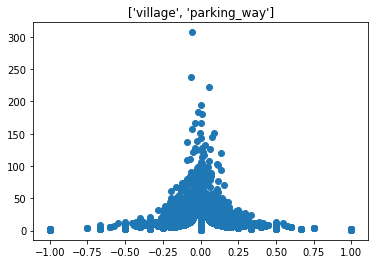

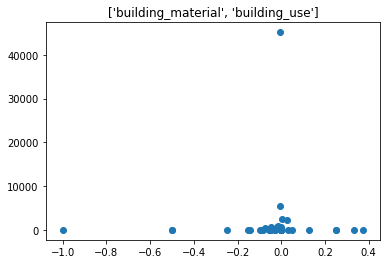

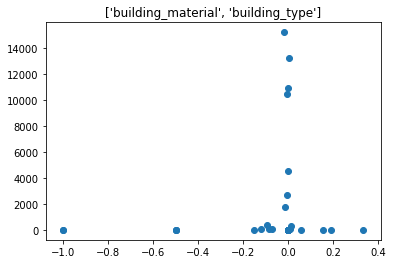

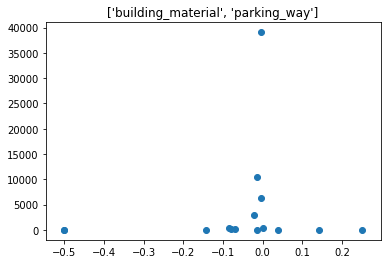

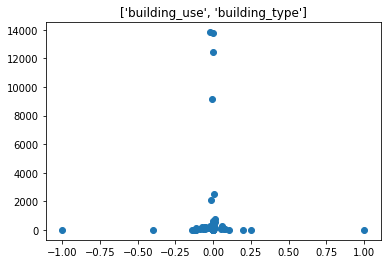

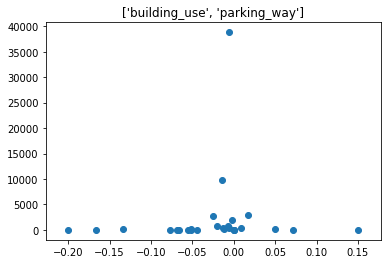

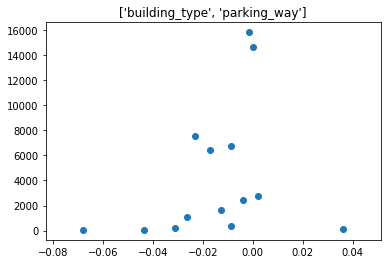

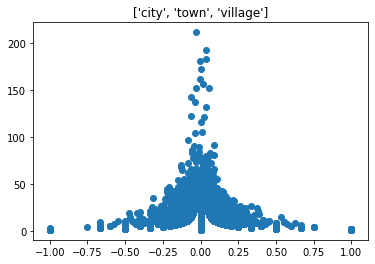

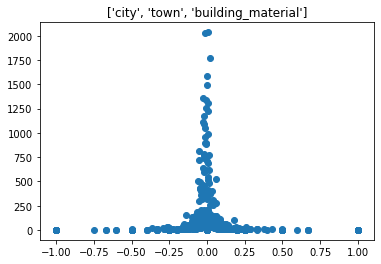

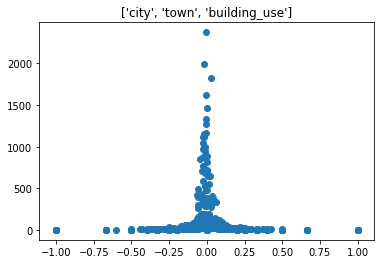

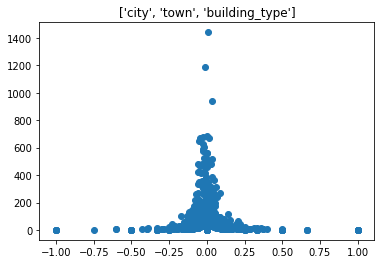

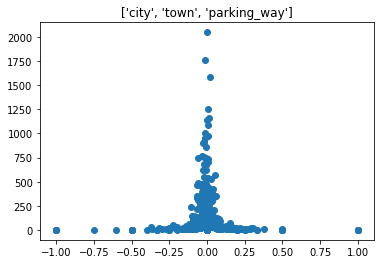

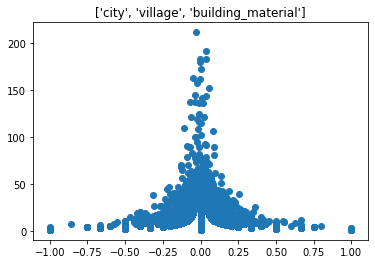

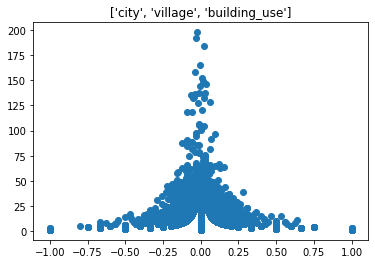

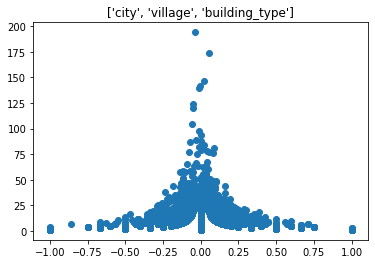

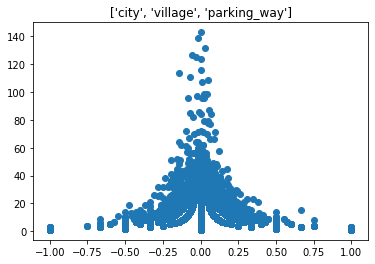

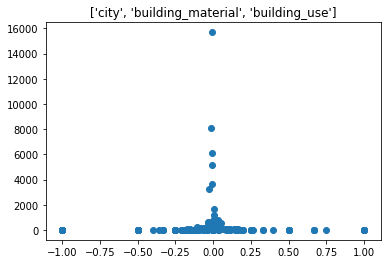

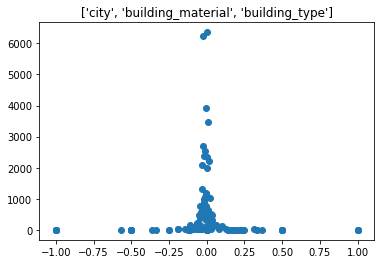

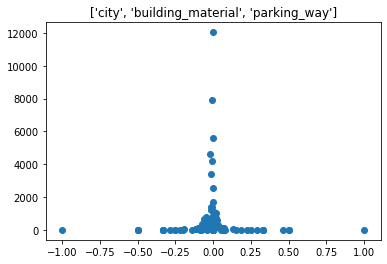

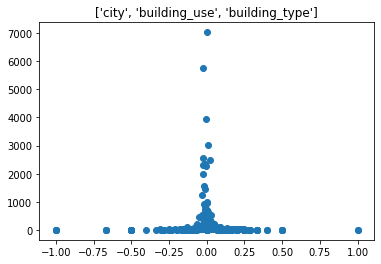

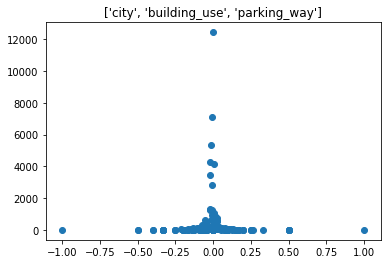

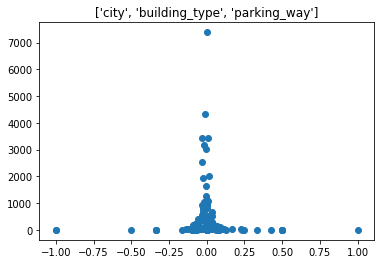

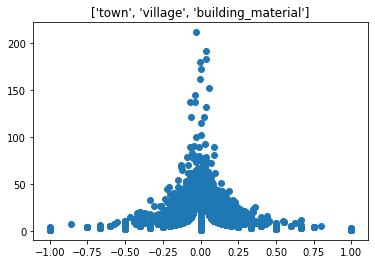

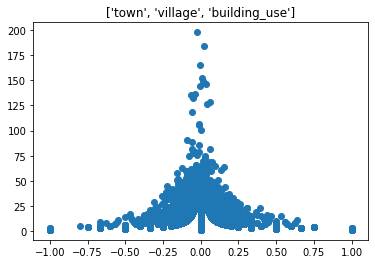

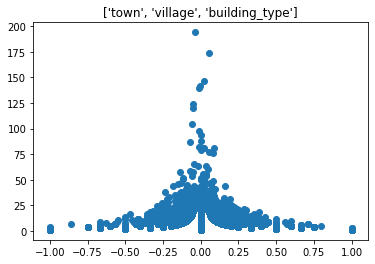

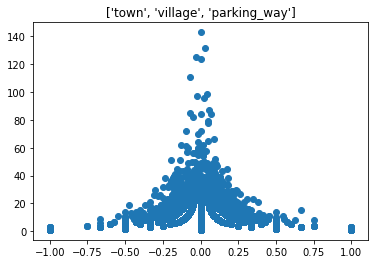

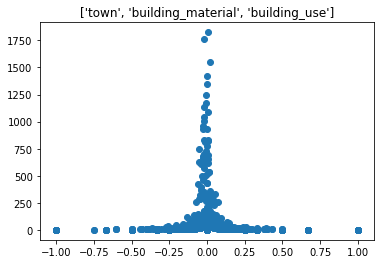

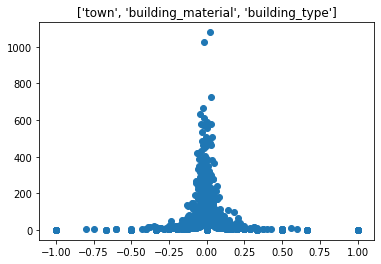

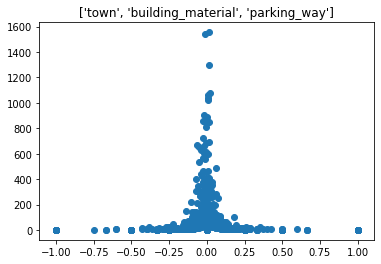

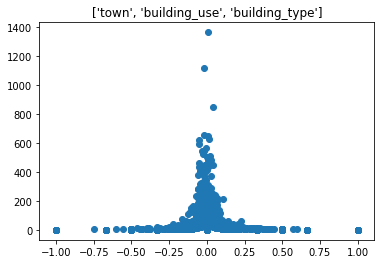

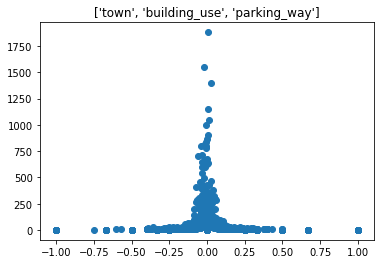

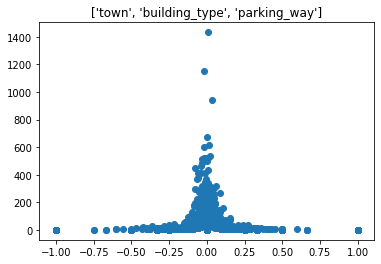

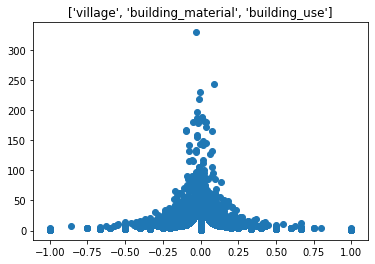

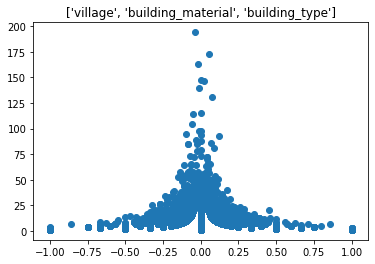

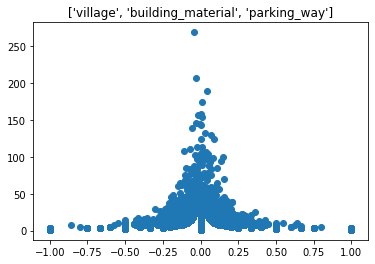

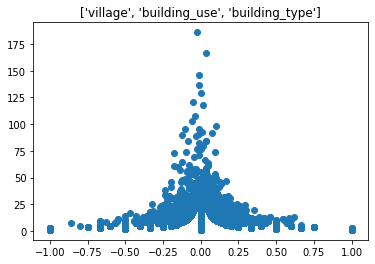

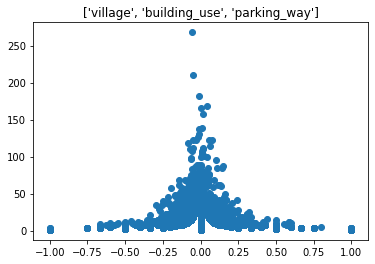

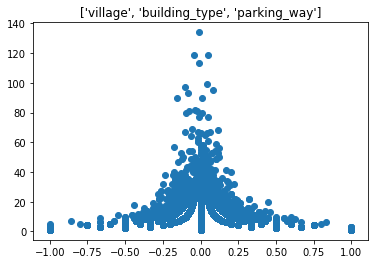

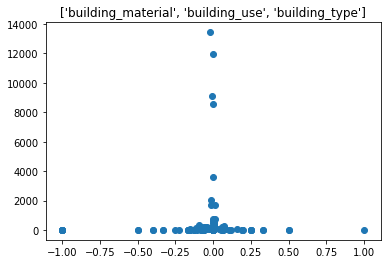

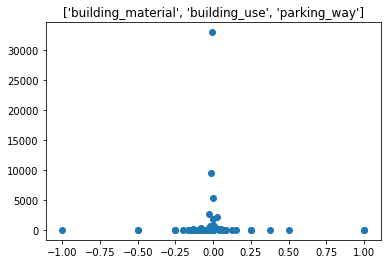

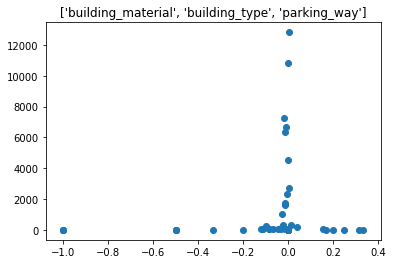

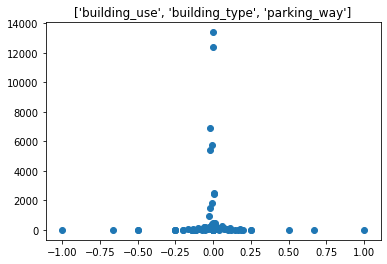

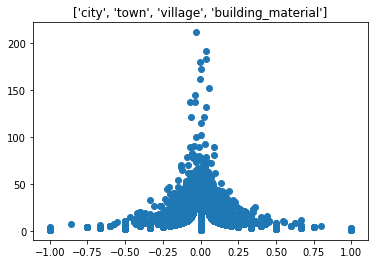

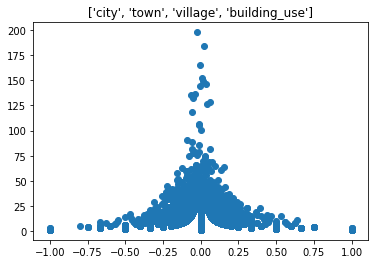

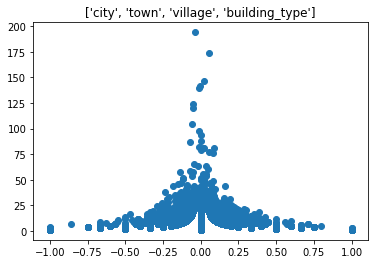

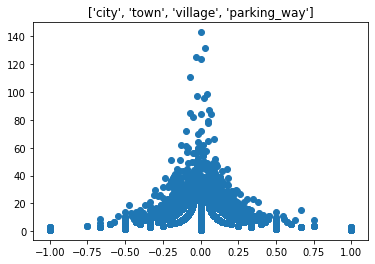

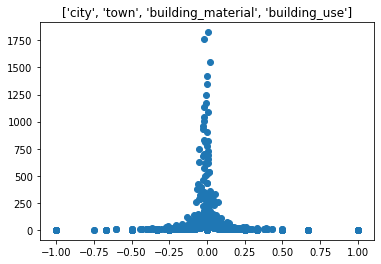

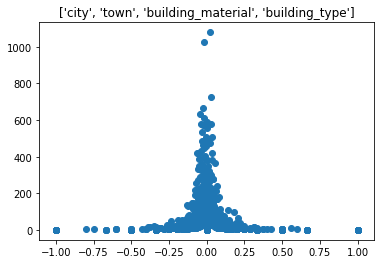

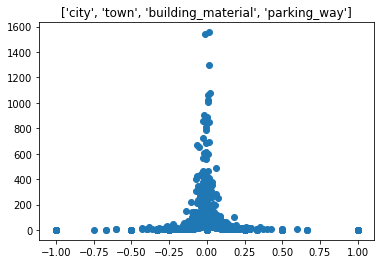

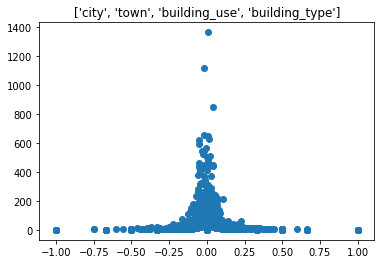

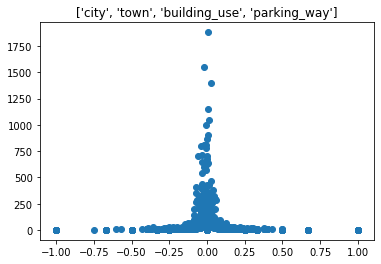

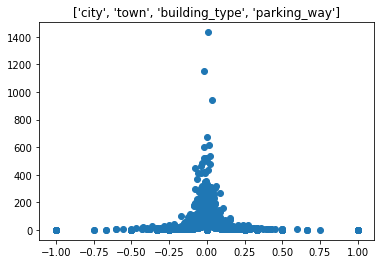

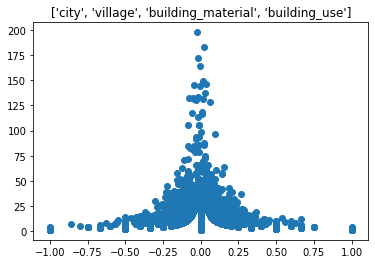

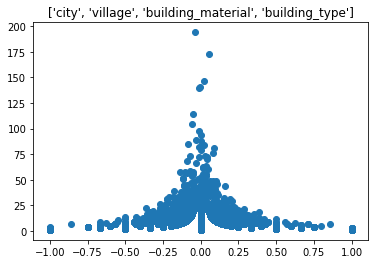

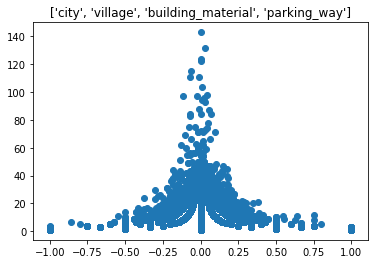

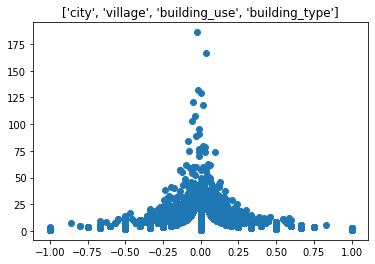

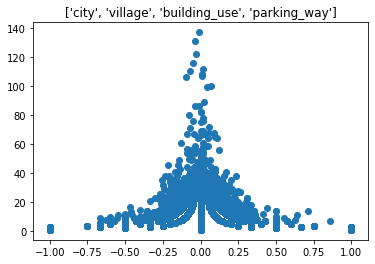

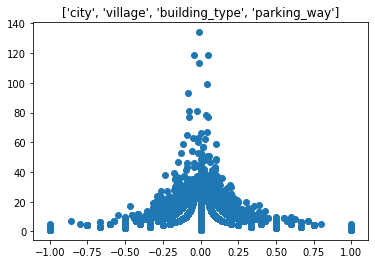

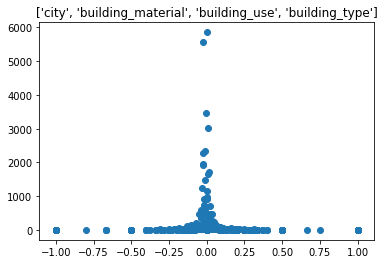

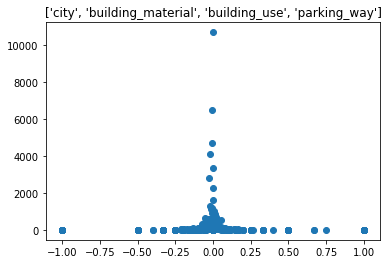

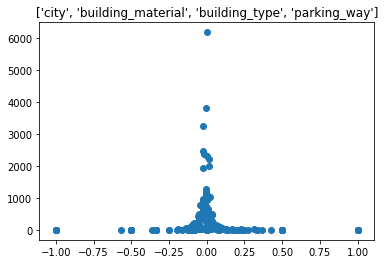

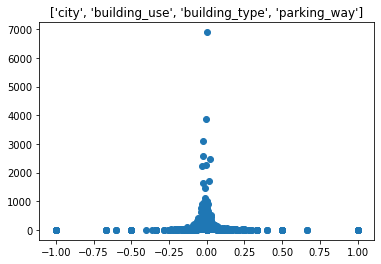

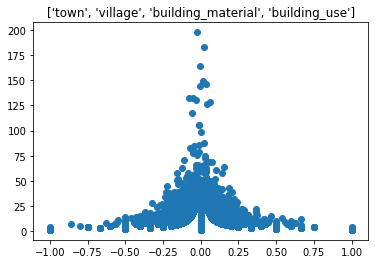

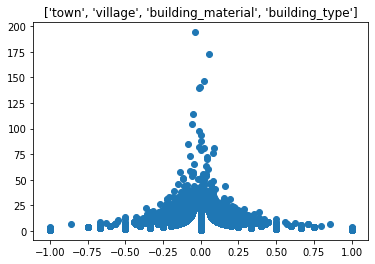

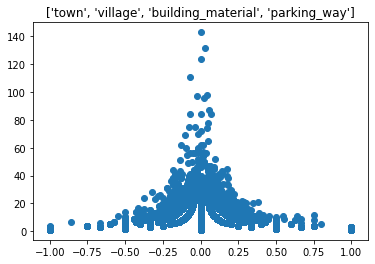

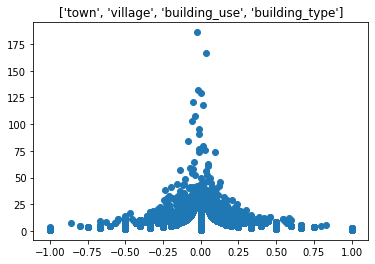

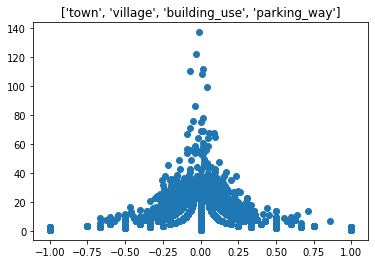

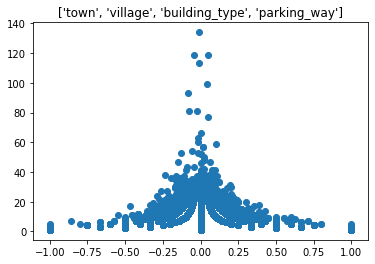

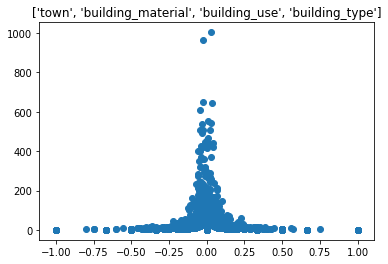

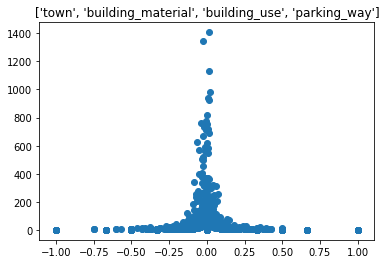

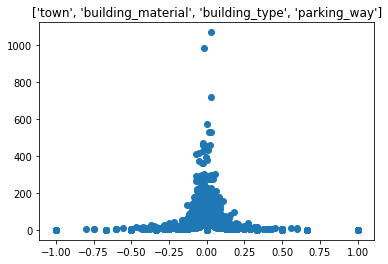

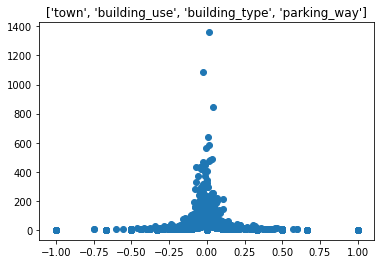

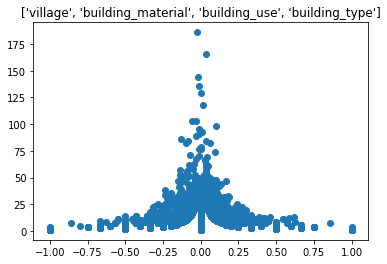

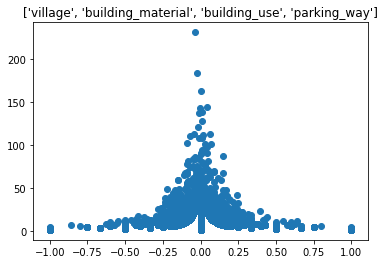

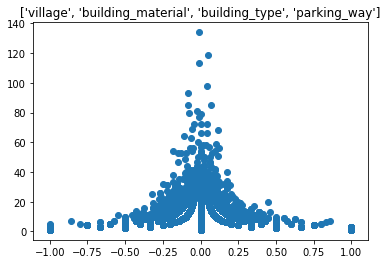

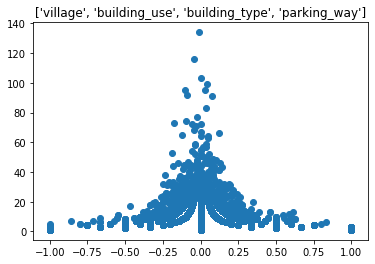

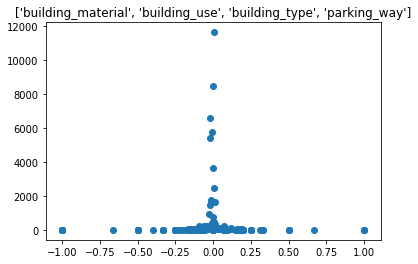

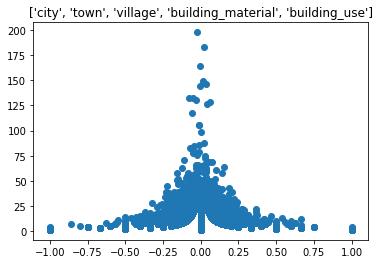

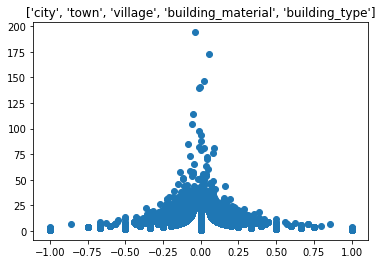

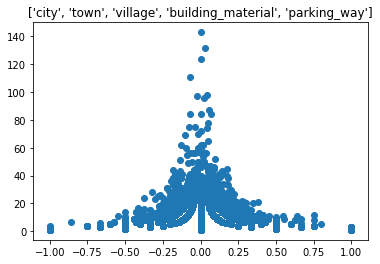

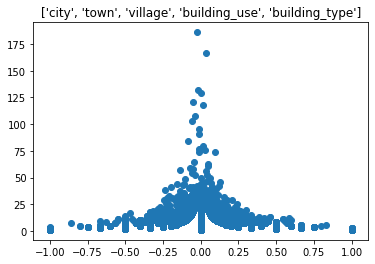

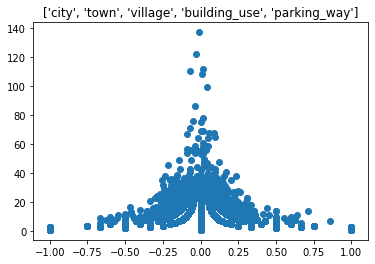

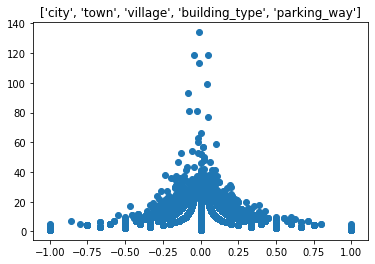

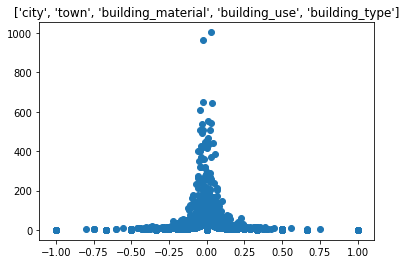

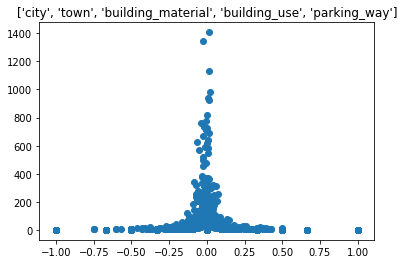

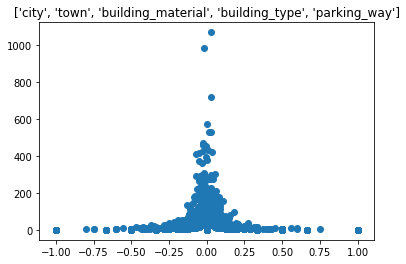

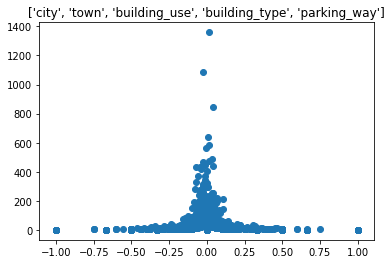

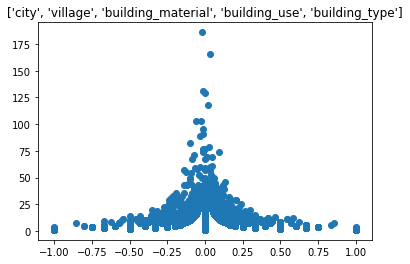

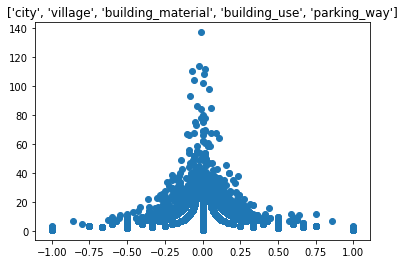

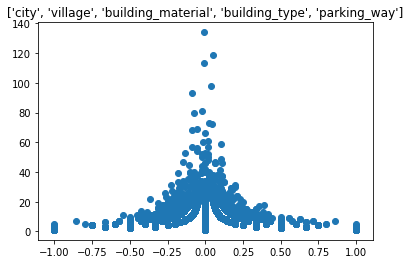

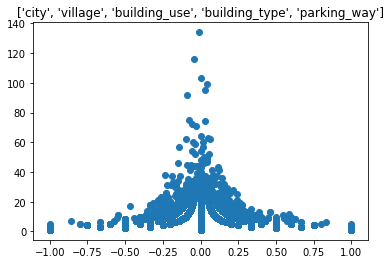

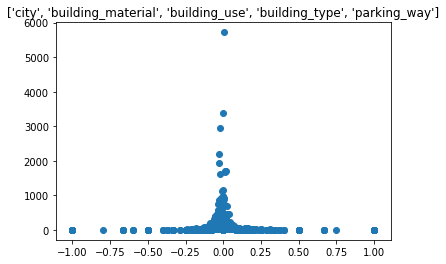

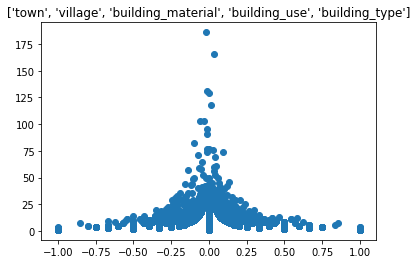

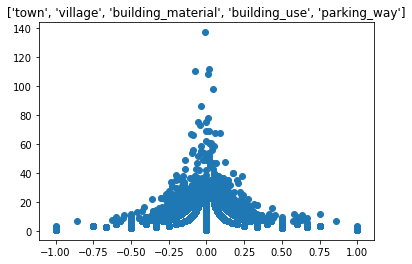

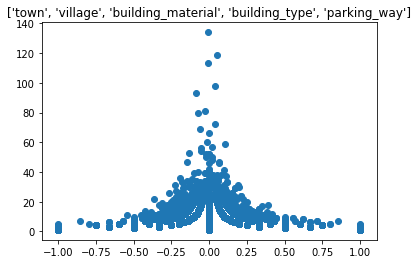

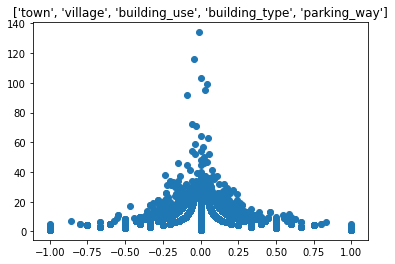

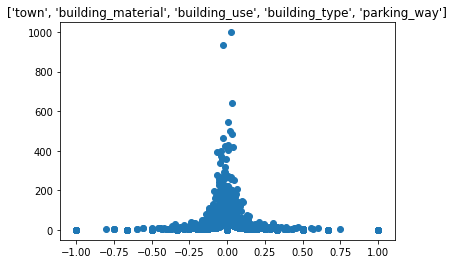

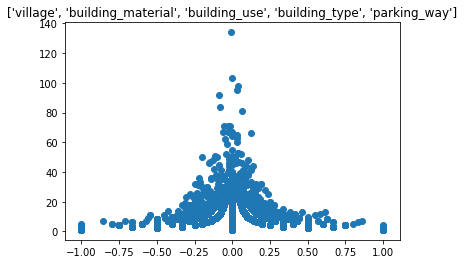

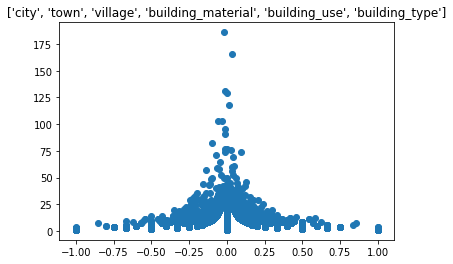

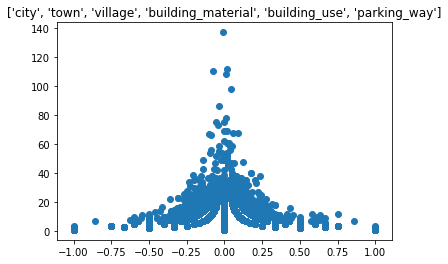

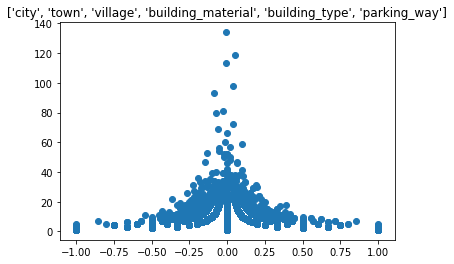

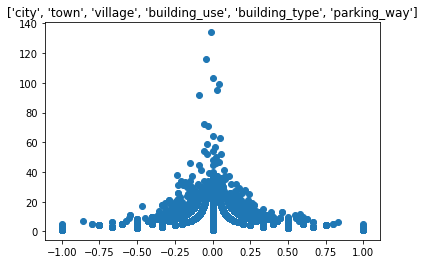

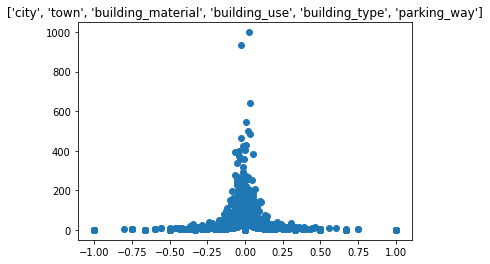

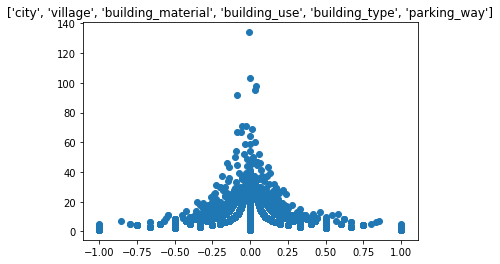

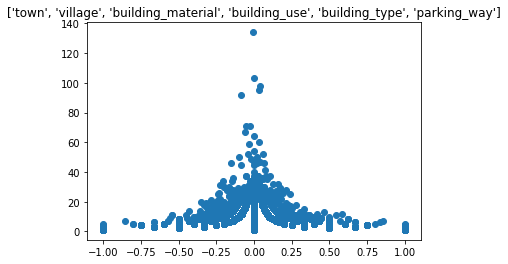

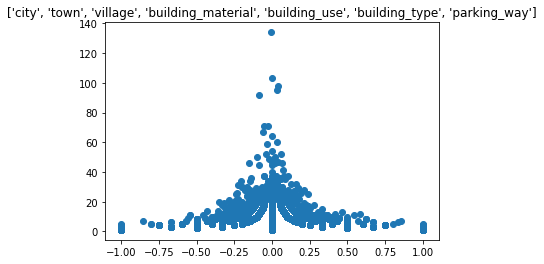

In [11]:
colnames = ['city', 'town', 'village', 'building_material', 'building_use', 'building_type', 'parking_way']

for combo_size in range(len(colnames)):
    for combo in combinations(colnames, combo_size + 1):
        combo = list(combo)
        ensemble_by_previous_validate_group_accuracy(train, combo, valid_result_1, valid_result_2)